# Exploring restaurants in Mumbai - India

# Introduction
The purpose of this project is to determine restaurants in Mumbai, India based on rating and average price. Restaurants will be identified in Mumbai, India using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best. People visiting a new city, start looking for restaurants during their stay. They primarily look for restaurant based on the rating and average price among all other restaurants near it such that the it fits their bill. Therefore, restaurants will be identified that are fit for various individuals based on the information collected from the two APIs and Data Science methodology.

# Data collection
Data will be fetched from following two APIs:
Foursquare API: to fetch restaurants in Mumbai within 5 KMs radius.
Zomato API: provides complete information of restaurant like address, user ratings, price for two people, price range and lot more.


In [1]:
mum_lat = 19.0760
mum_long = 72.8777

In [3]:
import folium

mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)
folium.Marker([mum_lat, mum_long]).add_to(mum_map)
mum_map.save("maps/Mumbai Map.html")
mum_map

# Foursquare API

In [4]:
FOURSQUARE_CLIENT_ID = 'O4DBKZ14Y2BMOMS2MT2KXE23ZMU0T54K5F5JFXJPLNOV2NO5'
FOURSQUARE_CLIENT_SECRET = 'JW3UGSMFMM3O2ZPA1SH154XYV5I1FYRPQFUQ3DZU4L1O35YU'
radius = 5000 # 5 Km
LIMIT = 100
VERSION = '20200520' # Current date

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    FOURSQUARE_CLIENT_ID, 
    FOURSQUARE_CLIENT_SECRET, 
    VERSION, 
    mum_lat, 
    mum_long, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=O4DBKZ14Y2BMOMS2MT2KXE23ZMU0T54K5F5JFXJPLNOV2NO5&client_secret=JW3UGSMFMM3O2ZPA1SH154XYV5I1FYRPQFUQ3DZU4L1O35YU&v=20200520&ll=19.076,72.8777&radius=5000&limit=100'

In [7]:
import requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f577de1ef734d51d05837a1'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Mumbai',
  'headerFullLocation': 'Mumbai',
  'headerLocationGranularity': 'city',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 19.121000045000045,
    'lng': 72.92522586516591},
   'sw': {'lat': 19.030999954999956, 'lng': 72.8301741348341}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5a21b1cea4236243c9628ad2',
       'name': 'Hitchki',
       'location': {'address': 'FIFC',
        'crossStreet': 'Bandra Kurla Complex, BKC',
        'lat': 19.069729972809867,
        'lng': 72.86976115276019,
        'labeledLatLngs': [{'label': 'display',
          'l

In [8]:
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Hitchki,Bar,19.069730,72.869761
1,Sofitel Mumbai BKC,Hotel,19.067448,72.869006
2,Hamleys,Toy / Game Store,19.086655,72.889783
3,Starbucks Coffee: A Tata Alliance,Coffee Shop,19.069457,72.869375
4,The Bar Stock Exchange,Bar,19.071166,72.876359


In [9]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


# Zomato API 

In [10]:
import numpy as np
import pandas as pd

headers = {'user-key': 'e56531ae67a1cdfe7958cd3219ed4c9e'}
venues_information = []

for index, row in nearby_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [11]:
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Pa Pa Ya,19.0550269727,72.8506127000,2600.0,4.0,4.6,"G-2, Ground Floor, North Avenue, Maker Maxity,..."
1,Tuskers - Sofitel,19.0673347825,72.8691501170,3300.0,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai"
2,Kale And Quinoa,19.0714804888,72.8240913525,1000.0,3.0,3.7,"Shop 2B, 1101-B28, Khatuo Eat, Union Park, Opp..."
3,Cafe Coffee Day,19.0724396618,72.8709971532,600.0,2.0,2.3,"Trade Center, Opp. MTNL, Bandra Kurla Complex,..."
4,The Bar Stock Exchange,19.0700783182,72.8765000403,1300.0,3.0,3.9,"1st Floor, Club House, Equinox Business Park, ..."


In [12]:
zomato_venues.dropna(inplace=True)
zomato_venues = zomato_venues.astype({"latitude": float, "longitude": float})
zomato_venues.dtypes

venue             object
latitude         float64
longitude        float64
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object

# Foursquare venues

In [13]:
mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)

for name, latitude, longitude in zip(nearby_venues['name'], nearby_venues['lat'], nearby_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mum_map)  

mum_map.save("maps/Venues by Foursquare.html")
mum_map

# Zomato restaurants near mumbai

In [14]:
mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mum_map)  

mum_map.save("maps/Venues by Zomato.html")
mum_map

## Overlapping of venues between Foursquare and Zomata API, so combining two datasets

In [15]:
nearby_venues['lat'] = nearby_venues['lat'].apply(lambda lat: round(float(lat), 4))
nearby_venues['lng'] = nearby_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [16]:
dataset = pd.concat([nearby_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [17]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sofitel Mumbai BKC,Hotel,19.0674,72.8690,Tuskers - Sofitel,19.0673,72.8692,3300.0,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",-0.0001,0.0002
1,Natural's Ice Cream,Ice Cream Shop,19.0776,72.8630,Natural Ice Cream,19.0776,72.8628,300.0,1.0,4.3,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",0.0000,-0.0002
2,Masala Library,Indian Restaurant,19.0689,72.8697,Masala Library,19.0690,72.8696,5000.0,4.0,4.8,"Ground Floor, First International Financial Ce...",0.0001,-0.0001
3,Trident,Hotel,19.0668,72.8675,O22 - Trident,19.0672,72.8675,4000.0,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",0.0004,0.0000
4,Smoke House Deli (BKC),Deli / Bodega,19.0688,72.8697,Smoke House Deli,19.0688,72.8695,2500.0,4.0,4.5,"3A, Ground Floor, 1st International Financial ...",0.0000,-0.0002
5,Phoenix Marketcity,Shopping Mall,19.0859,72.8887,Secondo - The Continental Chicken,19.0862,72.8889,500.0,2.0,0,"Unit S-32, 2nd Floor, Phoenix Market City, LBS...",0.0003,0.0002
6,IVY Restaurant & Banquets,Restaurant,19.0697,72.9005,Ivy Restaurant And Banquets,19.0696,72.9004,1600.0,3.0,4.2,"Near Shopper's Stop, Amar Mahal, M G Road, Che...",-0.0001,-0.0001
7,Theobrama,Dessert Shop,19.0635,72.8617,Theobroma,19.0637,72.8621,500.0,2.0,4.4,"The Capital, Ground Floor, Bandra Kurla Comple...",0.0002,0.0004
8,Starbucks,Coffee Shop,19.0866,72.8898,Starbucks Coffee,19.0865,72.8898,700.0,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",-0.0001,0.0000
9,Chembur Post Office Wada Pav,Snack Place,19.0569,72.8981,Oven Hot The Bake Shop,19.0569,72.8981,200.0,1.0,3.7,"4 & 5, Ganesh Kutir Building, Near Laxmi Store...",0.0000,0.0000


In [18]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0
1,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.3,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0
2,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.8,"Ground Floor, First International Financial Ce...",2500.0
3,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0
4,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.5,"3A, Ground Floor, 1st International Financial ...",1250.0


In [19]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 47


# Analysis

## Categories of restaurants

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

<BarContainer object of 22 artists>

## Ratings

Text(0.5, 1.0, 'Count of venues with given rating')

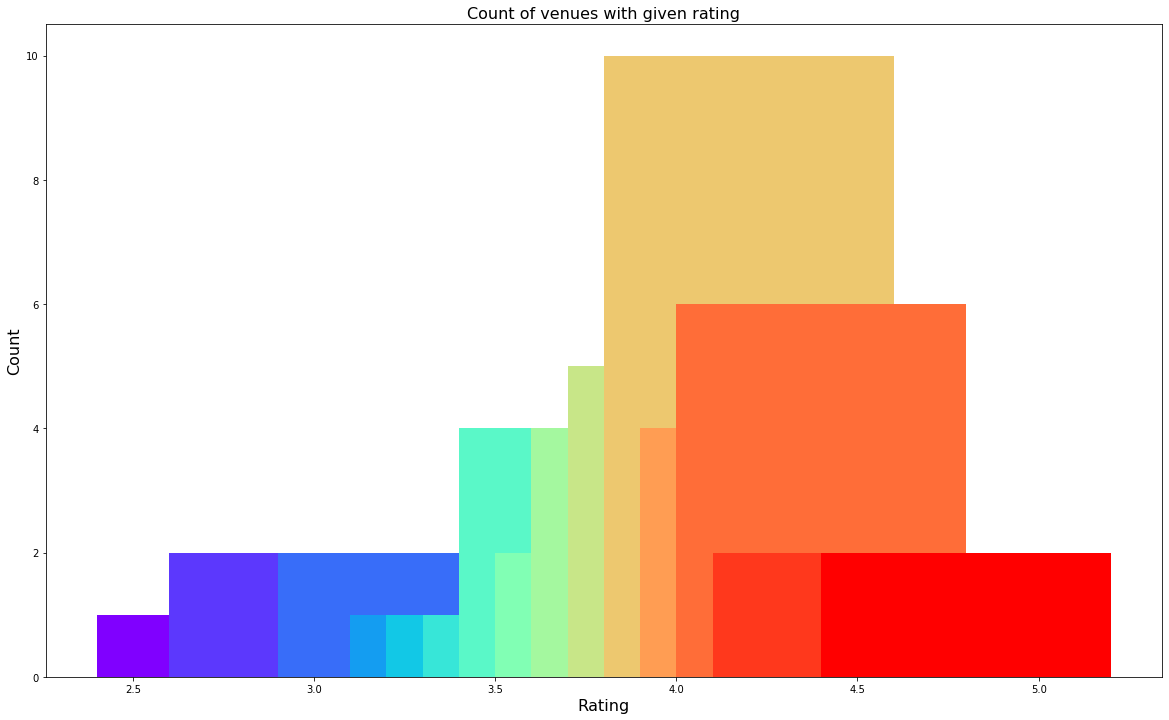

In [21]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [22]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Very good
1,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.3,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Very good
2,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.8,"Ground Floor, First International Financial Ce...",2500.0,Very good
3,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Very good
4,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.5,"3A, Ground Floor, 1st International Financial ...",1250.0,Very good


In [23]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mum_map)  

mum_map.save("maps/Venues Ratings.html")
mum_map

## Price

Text(0.5, 1.0, 'Count of venues with given average price')

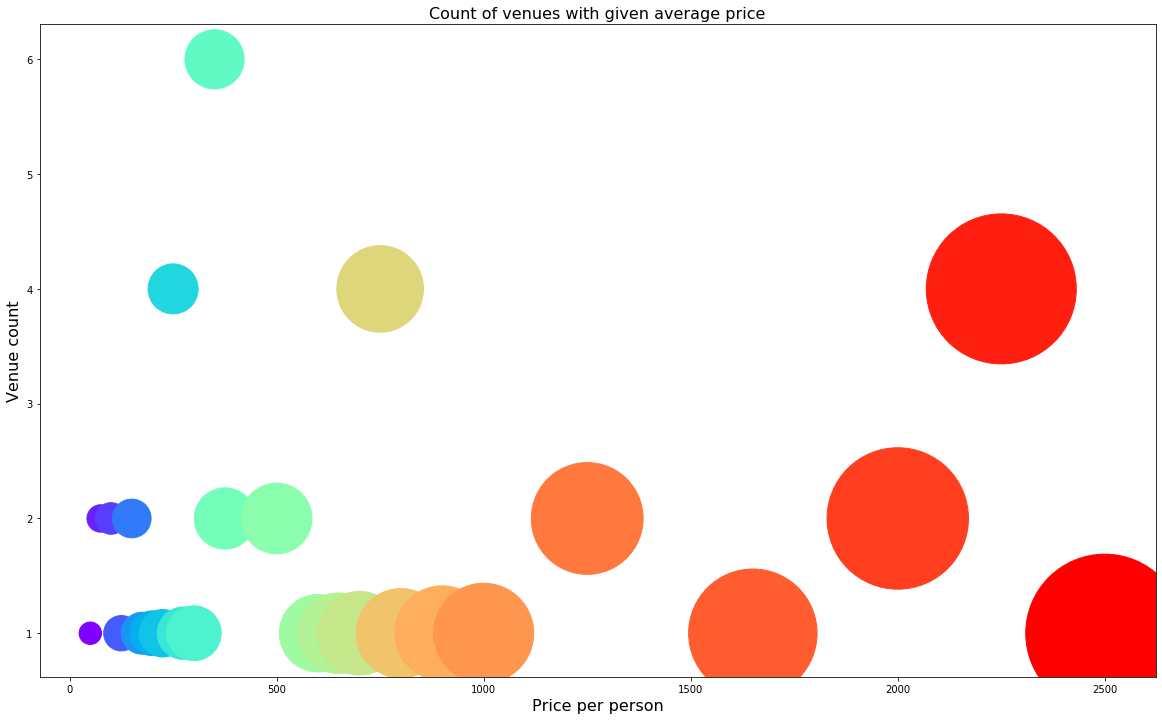

In [24]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [25]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(mum_map)  

mum_map.save("maps/Venues Prices.html")
mum_map

## Clustering

In [26]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Very good
1,1,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.3,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Very good
2,0,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.8,"Ground Floor, First International Financial Ce...",2500.0,Very good
3,0,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Very good
4,0,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.5,"3A, Ground Floor, 1st International Financial ...",1250.0,Very good


In [27]:
mum_map = folium.Map(location = [mum_lat, mum_long], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mum_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mum_map)

mum_map.save("maps/Venues Clusters.html")
mum_map

## comapre two clusters

In [28]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.3,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Very good
1,0,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.8,"Ground Floor, First International Financial Ce...",2500.0,Very good
2,0,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Very good
3,0,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.5,"3A, Ground Floor, 1st International Financial ...",1250.0,Very good
4,0,Hotel,JW Café - JW Marriott Mumbai Sahar,19.1025,72.8782,4.0,4.8,"IA Project Road, Chhatrapati Shivaji Internati...",2000.0,Very good
5,0,Restaurant,Glasshouse - Hyatt Regency Mumbai,19.1037,72.8714,4.0,4.2,"Hyatt Regency, Airport Sahar Road, Andheri Eas...",2250.0,Very good
6,0,Hotel,Glasshouse - Hyatt Regency Mumbai,19.1037,72.8714,4.0,4.2,"Hyatt Regency, Airport Sahar Road, Andheri Eas...",2250.0,Very good
7,0,Lounge,Glasshouse - Hyatt Regency Mumbai,19.1037,72.8714,4.0,4.2,"Hyatt Regency, Airport Sahar Road, Andheri Eas...",2250.0,Very good
8,0,Coffee Shop,Glasshouse - Hyatt Regency Mumbai,19.1037,72.8714,4.0,4.2,"Hyatt Regency, Airport Sahar Road, Andheri Eas...",2250.0,Very good
9,0,Lounge,Escobar - Tapas Bar,19.0600,72.8361,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",1250.0,Very good


In [29]:
print("These venues for cluster 0 has mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 has mean price range of 4.00 and rating spread around 4.35


In [30]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.3,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Very good
1,1,Restaurant,Ivy Restaurant And Banquets,19.0696,72.9004,3.0,4.2,"Near Shopper's Stop, Amar Mahal, M G Road, Che...",800.0,Very good
2,1,Dessert Shop,Theobroma,19.0637,72.8621,2.0,4.4,"The Capital, Ground Floor, Bandra Kurla Comple...",250.0,Very good
3,1,Coffee Shop,Starbucks Coffee,19.0865,72.8898,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",350.0,Very good
4,1,Snack Place,Oven Hot The Bake Shop,19.0569,72.8981,1.0,3.7,"4 & 5, Ganesh Kutir Building, Near Laxmi Store...",100.0,Good
5,1,Irani Cafe,SodaBottleOpenerWala,19.0638,72.8620,3.0,4.2,"Ground Floor, The Capital Building, G Block, B...",750.0,Very good
6,1,Indian Restaurant,Naaz Hotel,19.0846,72.8893,2.0,4.2,"Kantharia Mahal, LBS Road, Opposite Phoenix Ma...",350.0,Very good
7,1,Indian Restaurant,Delhi Zaika,19.0770,72.8784,2.0,3.8,"5/6, Near Kamran Kalpana Theater, LBS Marg, Ku...",350.0,Good
8,1,Beer Garden,Barbeque Nation,19.0863,72.8888,3.0,4.4,"S-49 &S-50, 2nd Floor, Phoenix Market City, LB...",650.0,Very good
9,1,Chinese Restaurant,Hotel Darshan,19.0828,72.8851,1.0,3.5,"Opposite Kohinoor City Gate, Kurla West, Near ...",125.0,Good


In [31]:
print("These venues for cluster 1 has mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 has mean price range of 2.05 and rating spread around 3.96


## Results

## Cluster-0 (green)
 1. Infrequently spread and has very limited restaurants.
 1. Has mean price range of 4.00 and rating spread around 4.23

## Cluster-1 (red)

1. Scattered across the city and includes the majority restaurants
1. Has mean price range of 2.11 and rating spread around 3.86

# Conclusion

## It can be concluded that Cluster-0 region is expensive and has a high rating and Cluster-1 region is in affordable price range and has mediocre rating